In [1]:
import numpy as np
import pandas as pd
import datasets
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle

In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


/home/profpao/Scrivania/NLP_playground/NLP_env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Import data

In [5]:
data_train = pd.read_csv('my_train.csv') 
data_test = pd.read_csv('my_test.csv')
data_val= pd.read_csv('my_val.csv')

In [6]:
data_train.head(2)

,Unnamed: 0,sentiment,text
0,12588,1,two rooms packed and cleaned three to go
1,1079,0,_nation just launched twittix v1 10 not convinced


In [7]:
# remove Unnamed:0 and use label instead of sentiment
train_df = pd.DataFrame({
    "label": data_train.sentiment.values,
    "text": data_train.text.values
})

val_df = pd.DataFrame({
    "label": data_val.sentiment.values,
    "text": data_val.text.values
})

test_df = pd.DataFrame({
    "label": data_test.sentiment.values,
    "text": data_test.text.values
})

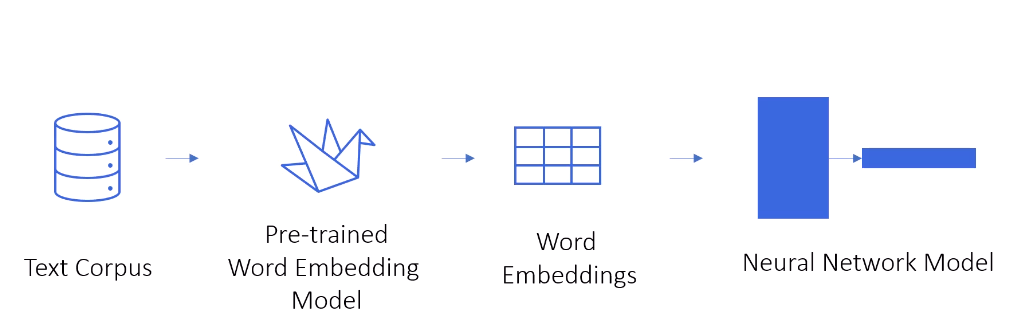

In [8]:
train_df.head()

,label,text
0,1,two rooms packed and cleaned three to go
1,0,_nation just launched twittix v1 10 not convinced
2,0,someone just censored up birthday censored for...
3,1,then i ll need plenty of quizzes to get throu...
4,2,just cos i dont have an ipod touch yet doesn t...


In [9]:
# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 10
MAX_FEATURES = 10

# Embedding step
[INFO EMBEDDING](https://huggingface.co/sentence-transformers/all-mpnet-base-v1)

In [10]:
# Embedding model
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1') 
sentence =["Hi, I am Paola"]
#embeddings = emb_model.encode(sentence)
#print(embeddings)

In [11]:
#print(embeddings.shape)

In [12]:
#print(embeddings.squeeze().shape)

In [13]:
y_train = train_df.label
y_test = test_df.label
y_val = val_df.label

In [14]:
train_df.text.shape

(18968,)

In [15]:

'''
X_train = emb_model.encode(train_df.text.values)

with open("X_train_embedde.pkl","wb") as output_file:
    pickle.dump(X_train, output_file)
'''
with open("X_train_embedde.pkl","rb") as input_file:
    X_train = pickle.load(input_file)


In [16]:
X_train.shape

(18968, 768)

In [17]:
'''
X_test = emb_model.encode(test_df.text.values)


with open("X_test_embedde.pkl","wb") as output_file:
    pickle.dump(X_test, output_file)
'''
with open("X_test_embedde.pkl","rb") as input_file:
    X_test = pickle.load(input_file)
    

In [18]:
X_val = emb_model.encode(val_df.text.values)

'''
with open("X_val_embedde.pkl","wb") as output_file:
    pickle.dump(X_val, output_file)
'''
with open("X_val_embedde.pkl","rb") as input_file:
    X_val = pickle.load(input_file)


# Dataset class

In [19]:
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,index):
        return self.X[index], self.y[index]

In [20]:
train_ds = SentimentData(X = X_train, y = y_train)
eval_ds = SentimentData(X= X_val, y = y_val)

In [21]:
test_ds = SentimentData(X= X_test, y = y_test)

In [22]:
X_val.shape

(2108, 768)

# DataLoader

In [23]:
BATCH_SIZE = 128
train_loader = DataLoader(dataset= train_ds, batch_size = BATCH_SIZE, shuffle = True)
eval_loader = DataLoader(eval_ds, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE)

# Model

In [24]:
class NAIVESentimentModel(nn.Module):
    
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 384):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu= nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return(x)
    

# CNN Architecture

![Formula CNN](https://i0.wp.com/syncedreview.com/wp-content/uploads/2017/05/13.png?resize=330%2C230&ssl=1)

In [25]:
'''
class SentimentModelCNN_2(nn.Module):
    
    def __init__(self, NUM_FEATURES,NUM_CLASSES, HIDDEN= 768):
        super().__init__()
        
        #NUM_FEATURES = 768
        self.input = nn.Linear(NUM_FEATURES, HIDDEN) 
        self.relu= nn.ReLU()
        self.reluL =nn.LeakyReLU()
        self.conv1= nn.Conv1d(1, 32,3)
        self.conv2 = nn.Conv1d(32,64,3) 

        self.linear = nn.Linear(64*190, 6080)
        self.linear2 = nn.Linear(6080, 1520)
        self.linear3 = nn.Linear(1520, NUM_CLASSES)
        #fully connected layer
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        
        x = self.input(x) #out:768
        x = self.relu(x)
        
        # Remove first param torch, batch_size, otherwise it computes as a in_channel
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x)) #out 766
        x = F.max_pool1d(x,2) #out: 383
        x = F.relu(self.conv2(x)) #out:381
        x = F.max_pool1d(x, kernel_size=2) #out: 190


        #flatten 
        x= x.view(-1, 64*190)

        
        #classification task
        x = F.leaky_relu(self.linear(x))
        x = F.leaky_relu(self.linear2(x))
        x = self.linear3(x)
       
        x = F.log_softmax(x, dim =1)

        #return the batch_size dimension
        x = x.squeeze()
        return x
    '''

'\nclass SentimentModelCNN_2(nn.Module):\n    \n    def __init__(self, NUM_FEATURES,NUM_CLASSES, HIDDEN= 768):\n        super().__init__()\n        \n        #NUM_FEATURES = 768\n        self.input = nn.Linear(NUM_FEATURES, HIDDEN) \n        self.relu= nn.ReLU()\n        self.reluL =nn.LeakyReLU()\n        self.conv1= nn.Conv1d(1, 32,3)\n        self.conv2 = nn.Conv1d(32,64,3) \n\n        self.linear = nn.Linear(64*190, 6080)\n        self.linear2 = nn.Linear(6080, 1520)\n        self.linear3 = nn.Linear(1520, NUM_CLASSES)\n        #fully connected layer\n        self.log_softmax = nn.LogSoftmax(dim=1)\n\n    def forward(self,x):\n        \n        x = self.input(x) #out:768\n        x = self.relu(x)\n        \n        # Remove first param torch, batch_size, otherwise it computes as a in_channel\n        x = x.unsqueeze(1)\n        x = F.relu(self.conv1(x)) #out 766\n        x = F.max_pool1d(x,2) #out: 383\n        x = F.relu(self.conv2(x)) #out:381\n        x = F.max_pool1d(x, kernel_

In [26]:
class SentimentModelCNN(nn.Module):
    
    def __init__(self, NUM_FEATURES,NUM_CLASSES, HIDDEN = 384):
        super().__init__()
        
        #NUM_FEATURES = 768
        self.input = nn.Linear(NUM_FEATURES, HIDDEN) 
        self.encoder = nn.Linear(HIDDEN, 184) 
        self.relu= nn.ReLU()

        self.conv1= nn.Conv1d(1, 32,3)
        self.conv2 = nn.Conv1d(32,64,3) 

        self.linear = nn.Linear(64*44, 64*22)
        self.linear2 = nn.Linear(64*22, NUM_CLASSES)
        
        #fully connected layer
        #self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.input(x) #out:384
        x = self.relu(x)
        x = self.encoder(x) #out: 184
        x = self.relu(x)
        
        # Remove first param torch, batch_size, otherwise it compute as a in_channel
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x)) #out 182
        x = F.max_pool1d(x,2) #out: 91
        x = F.relu(self.conv2(x)) #out:89
        x = F.max_pool1d(x, kernel_size=2) #out: 44


        #flatten 
        x= x.view(-1, 64*44)

        
        #classification task
        x = F.relu(self.linear(x))
        x= self.linear2(x)
        #x = self.log_softmax(x)
        x = F.log_softmax(x, dim =1)

        #return the batch_size dimension
        x = x.squeeze()
        return x
    

In [27]:
'''
model = NAIVESentimentModel( NUM_FEATURES = X_train.shape[1],
                       NUM_CLASSES = 3)

model = SentimentModelCNN( NUM_FEATURES = X_train.shape[1],
                       NUM_CLASSES = 3)

                       
model = SentimentModelCNN_2( NUM_FEATURES = X_train.shape[1],
                       NUM_CLASSES = 3)
'''

'\nmodel = NAIVESentimentModel( NUM_FEATURES = X_train.shape[1],\n                       NUM_CLASSES = 3)\n\nmodel = SentimentModelCNN( NUM_FEATURES = X_train.shape[1],\n                       NUM_CLASSES = 3)\n\n                       \nmodel = SentimentModelCNN_2( NUM_FEATURES = X_train.shape[1],\n                       NUM_CLASSES = 3)\n'

In [28]:
model = SentimentModelCNN( NUM_FEATURES = X_train.shape[1],
                       NUM_CLASSES = 3)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())


In [29]:
#train_losses = []
NUM_EPOCHS = 5
train_losses =[]
validation_losses=[]

for e in range(NUM_EPOCHS):
    curr_loss = 0
    


    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        #X_batch = X_batch.unsqueeze(1)
        y_pred_log = model(X_batch)
        #print(y_pred_log.shape)
        #print(y_batch.shape)
        loss = criterion(y_pred_log, y_batch.long())
        curr_loss += loss.item() # Accumulate the loss of the current batch
        loss.backward()
        optimizer.step()
    
    
    curr_loss /= len(train_loader) # Calculate the average training loss across all batches in the epoch
    train_losses.append(curr_loss)
   
   
   # Validation    
    model.eval()
    with torch.no_grad():
        val_inputs, val_labels = next(iter(eval_loader))  # Get data from validation loader
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels.long()) #val_labels
        val_loss += val_loss.item() # Accumulate the loss of the current batch
        predicted = torch.argmax(val_outputs, 1)
        predicted = predicted.cpu().numpy()
        val_acc = (predicted == val_labels).sum().item() / len(val_labels)
    
    
    val_loss /= len(eval_loader) # Calculate the average training loss across all batches in the epoch
    validation_losses.append(val_loss)

    print(f"Epoch [{e+1}/{NUM_EPOCHS}], Train Loss: {curr_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")   
    
    #train_losses.append(curr_loss)
    #print(f"Epoch {e}, Loss: {curr_loss:.4}")


Epoch [1/5], Train Loss: 0.8757, Val Loss: 0.0869, Val Acc: 0.6406
Epoch [2/5], Train Loss: 0.6742, Val Loss: 0.0810, Val Acc: 0.6875
Epoch [3/5], Train Loss: 0.6274, Val Loss: 0.0785, Val Acc: 0.7266
Epoch [4/5], Train Loss: 0.5761, Val Loss: 0.0727, Val Acc: 0.7656
Epoch [5/5], Train Loss: 0.4976, Val Loss: 0.0808, Val Acc: 0.7109


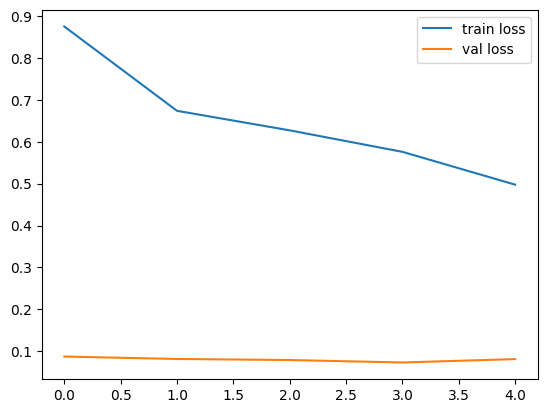

In [30]:
#plot loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(validation_losses, label='val loss')
plt.legend()

# Test the model

In [31]:
# Model evaluation with test set
model.eval()
y_test_pred_all = []  # Store predictions for all batches

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        #print(X_batch.shape) #[128,1,768] >>[1,768]
        y_test_pred_log = model(X_batch)
        #print(y_test_pred_log.data)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)
        y_test_pred_all.extend(y_test_pred.cpu().numpy())

In [32]:
acc = accuracy_score(y_pred = y_test_pred_all, y_true = y_test)
round(acc,3)

0.694

Classification_report
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1792
           1       0.65      0.51      0.57      1731
           2       0.69      0.84      0.76      1747

    accuracy                           0.69      5270
   macro avg       0.69      0.69      0.69      5270
weighted avg       0.69      0.69      0.69      5270

Confusion Matrix


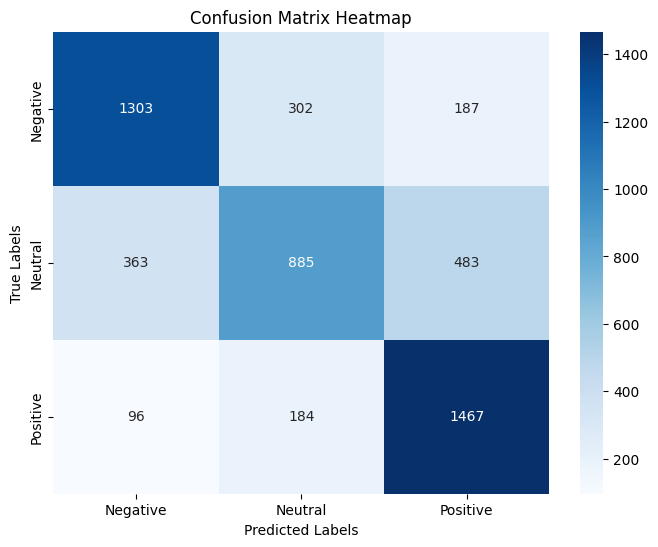

In [33]:
y_pred = y_test_pred_all
y_true = y_test
accuracy_score(y_true,y_pred)
print(f'Classification_report')
print(classification_report(y_true=y_true,y_pred=y_pred))
print(f'Confusion Matrix')
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()